In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [ ]:
train_data.head()

,k,x
0,1,2.501035
1,2,3.257858
2,3,3.551333
3,4,3.513895
4,5,3.491913


In [ ]:
train_data.shape

(100, 2)

In [ ]:
test_data.head()

,k
0,101
1,102
2,103
3,104
4,105


In [ ]:
test_data.shape

(20, 1)

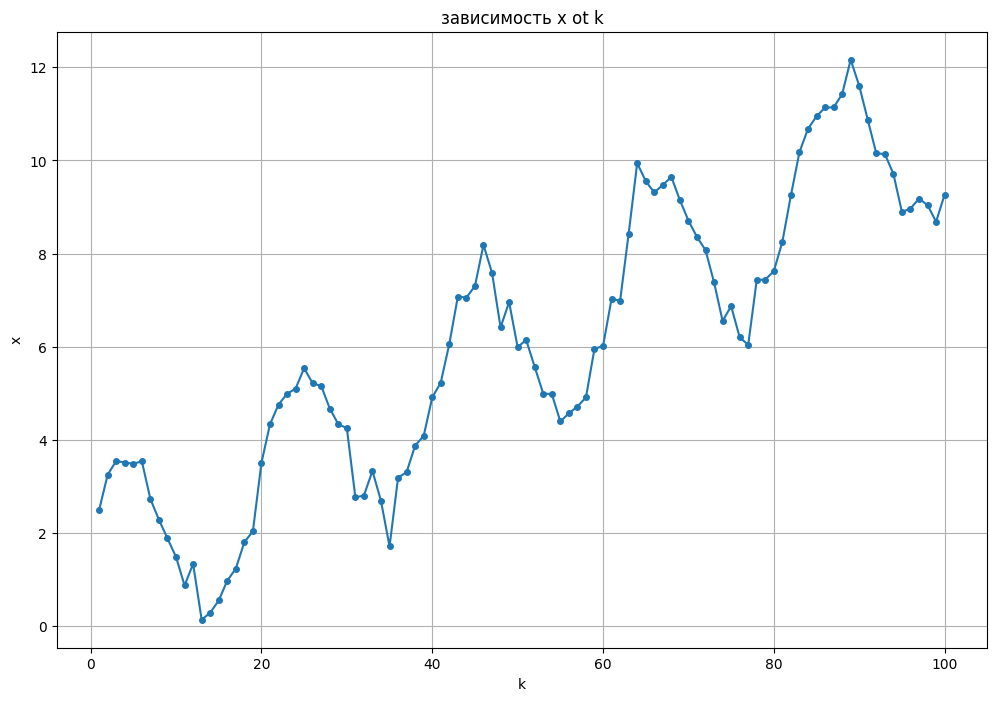

In [ ]:
#визуализация зависимости x от k
plt.figure(figsize = (12, 8))
plt.plot(train_data['k'], train_data['x'], marker = 'o', markersize = 4)
plt.xlabel('k')
plt.ylabel('x')
plt.title('зависимость x ot k')
plt.grid()
plt.show()

In [ ]:
#разделение данных на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(train_data[['k']], train_data['x'], test_size = 0.2, random_state = 42, shuffle = False)

In [ ]:
#создание модели линейной регрессии
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
#получение коффициентов линейной регрессии
b = lin_model.coef_[0]
c = lin_model.intercept_

print(f'params: b = {b:.4f}, c = {c:.4f}')

params: b = 0.0865, c = 1.5282


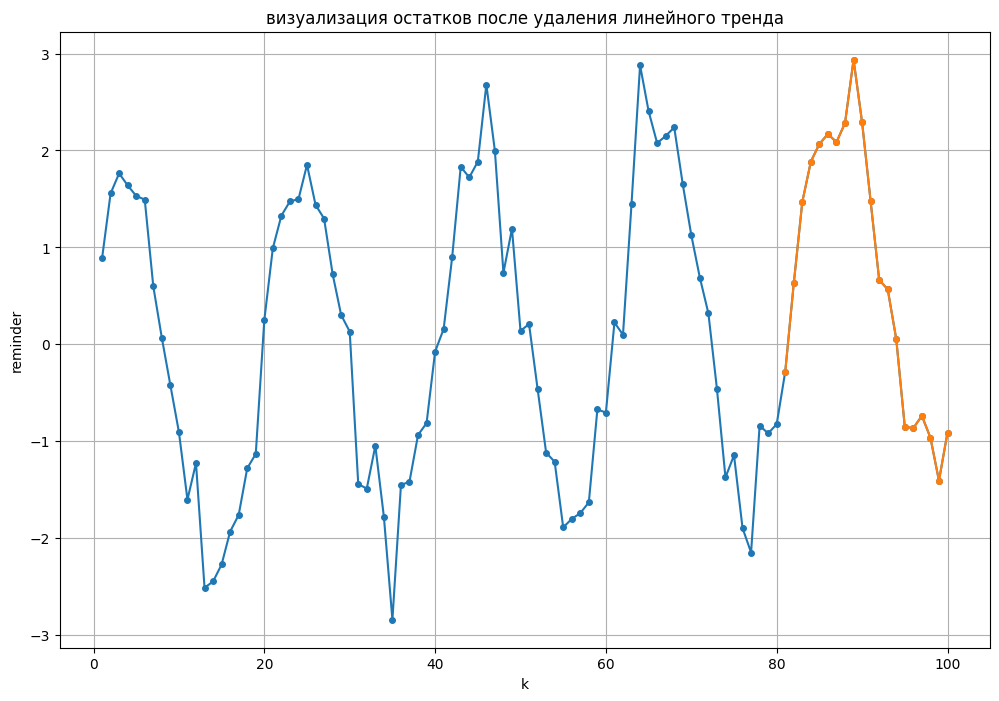

In [ ]:
#отбрасывание линейного тренда и визуализация остатков
train_data['reminder'] = train_data['x'] - (b * train_data['k'] + c)
valid_data = pd.DataFrame({'k': X_valid['k'], 'x': y_valid})
valid_data['reminder'] = valid_data['x'] - (b * valid_data['k'] + c)

plt.figure(figsize = (12, 8))
plt.plot(train_data['k'], train_data['reminder'], marker = 'o', markersize = 4)
plt.plot(valid_data['k'], valid_data['reminder'], marker = 'o', markersize = 4)
plt.xlabel('k')
plt.ylabel('reminder')
plt.title('визуализация остатков после удаления линейного тренда')
plt.grid()
plt.show()

In [ ]:
#получение параметров остатка
def sin_func(k, a, w, phi):
  return a * np.sin(w * k + phi)

param, _ = curve_fit(sin_func, train_data['k'], train_data['reminder'], p0 = [1, 0.1, 0])

a, w, phi = param
print(f"params: a = {a:.4f}, w = {w:.4f}, phi = {phi:.4f}")

params: a = 0.4574, w = 0.0675, phi = 2.7564


In [ ]:
#создание полной модели
def model1(k, a, w, phi, b, c):
  return a * np.sin(w * k + phi) + b * k + c

In [ ]:
#предсказание на тренировочной и валидационной выборках, рассчет функции потерь
train_data['pred'] = model1(train_data['k'], a, w, phi, b, c)
valid_data['pred'] = model1(valid_data['k'], a, w, phi, b, c)

mse_train = mean_squared_error(train_data['x'], train_data['pred'])
mse_valid = mean_squared_error(valid_data['x'], valid_data['pred'])

print(f"MSE на обучающих данных 1: {mse_train:.4f}")
print(f"MSE на валидационных данных 1: {mse_valid:.4f}")

MSE на обучающих данных 1: 2.0989
MSE на валидационных данных 1: 1.8217


In [ ]:
#вычисление суммы квадратов ошибок, подбор параметров для минимизации функции потерь
def loss(params):
    a, w, phi, b, c = params
    predictions = model1(train_data['k'], a, w, phi, b, c)
    return np.sum((predictions - y_train) ** 2)

bounds = [(-5, 5), (0, 2), (-np.pi, np.pi), (-1, 1), (-10, 10)]

result = differential_evolution(loss, bounds)
popt = result.x

In [ ]:
#предсказание на тренировочной и валидационной выборках c подобранными параметрами, рассчет функции потерь
a_opt, w_opt, phi_opt, b_opt, c_opt = popt
train_data['pred_optim'] = model1(train_data['k'], a_opt, w_opt, phi_opt, b_opt, c_opt)
valid_data['pred_optim'] = model1(valid_data['k'], a_opt, w_opt, phi_opt, b_opt, c_opt)

mse_train = mean_squared_error(train_data['x'], train_data['pred_optim'])
mse_valid = mean_squared_error(valid_data['x'], valid_data['pred_optim'])

print(f"MSE на обучающих данных 2: {mse_train:.4f}")
print(f"MSE на валидационных данных 2: {mse_valid:.4f}")

MSE на обучающих данных 2: 0.1086
MSE на валидационных данных 2: 0.1111


In [ ]:
#получение рпедсказаний на тестовой выборке
test_data['x'] = model1(test_data['k'], a_opt, w_opt, phi_opt, b_opt, c_opt)

test_data.to_csv('pred1.csv', index = False)

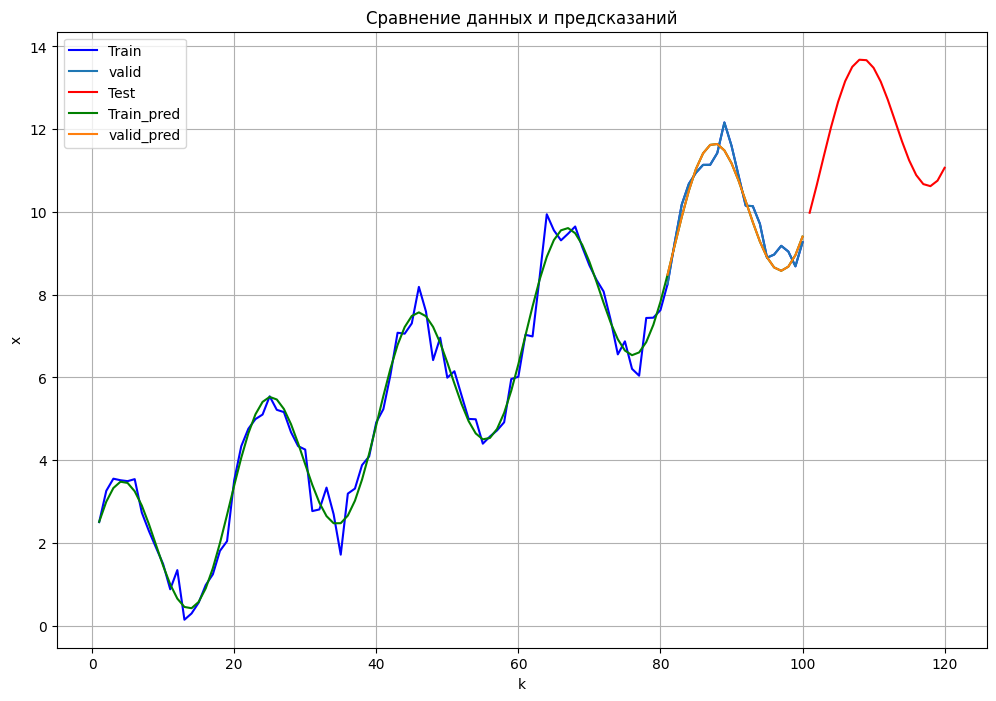

In [ ]:
#визуализация данных и предсказаний
plt.figure(figsize = (12, 8))
plt.plot(train_data['k'], train_data['x'], label = 'Train', color = 'blue')
plt.plot(valid_data['k'], valid_data['x'], label = 'valid')
plt.plot(test_data['k'], test_data['x'], label='Test', color = 'red')
plt.plot(train_data['k'], train_data['pred_optim'], label = 'Train_pred', color = 'green')
plt.plot(valid_data['k'], valid_data['pred_optim'], label = 'valid_pred')
plt.xlabel('k')
plt.ylabel('x')
plt.title('Сравнение данных и предсказаний')
plt.legend()
plt.grid()
plt.show()

ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
#создание модели ElasticNet, получение коэффициентов
elastic_model = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
elastic_model.fit(X_train, y_train)

b_elastic = elastic_model.coef_[0]
c_elastic = elastic_model.intercept_

print(f"Параметры ElasticNet: b = {b_elastic:.4f}, c = {c_elastic:.4f}")

Параметры ElasticNet: b = 0.0864, c = 1.5323


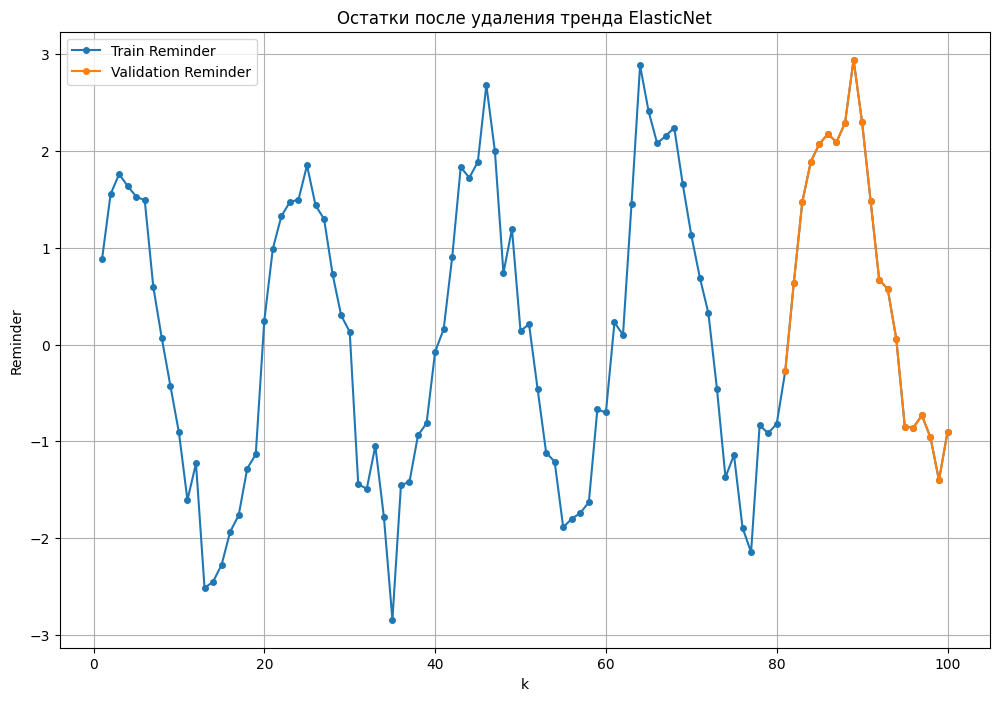

In [ ]:
#отбрасывание линейного тренда и визуализация остатков
train_data['reminder_elastic'] = train_data['x'] - (b_elastic * train_data['k'] + c_elastic)
valid_data['reminder_elastic'] = valid_data['x'] - (b_elastic * valid_data['k'] + c_elastic)

plt.figure(figsize=(12, 8))
plt.plot(train_data['k'], train_data['reminder_elastic'], marker='o', markersize=4, label='Train Reminder')
plt.plot(valid_data['k'], valid_data['reminder_elastic'], marker='o', markersize=4, label='Validation Reminder')
plt.xlabel('k')
plt.ylabel('Reminder')
plt.title('Остатки после удаления тренда ElasticNet')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#получение параметров остатка
def sin_func(k, a, w, phi):
    return a * np.sin(w * k + phi)

param, _ = curve_fit(sin_func, train_data['k'], train_data['reminder_elastic'], p0=[1, 0.1, 0])

a_elastic, w_elastic, phi_elastic = param
print(f"Параметры синусоиды (ElasticNet): a = {a_elastic:.4f}, w = {w_elastic:.4f}, phi = {phi_elastic:.4f}")

Параметры синусоиды (ElasticNet): a = 0.4599, w = 0.0673, phi = 2.7642


In [ ]:
# Полная модель
def model_elastic(k, a, w, phi, b, c):
    return a * np.sin(w * k + phi) + b * k + c

train_data['pred_elastic'] = model_elastic(train_data['k'], a_elastic, w_elastic, phi_elastic, b_elastic, c_elastic)
valid_data['pred_elastic'] = model_elastic(valid_data['k'], a_elastic, w_elastic, phi_elastic, b_elastic, c_elastic)

mse_train_elastic = mean_squared_error(train_data['x'], train_data['pred_elastic'])
mse_valid_elastic = mean_squared_error(valid_data['x'], valid_data['pred_elastic'])

print(f"MSE на обучающих данных ElasticNet 1: {mse_train_elastic:.4f}")
print(f"MSE на валидационных данных ElasticNet 1: {mse_valid_elastic:.4f}")

MSE на обучающих данных ElasticNet 1: 2.0990
MSE на валидационных данных ElasticNet 1: 1.8226


In [ ]:
# Функция потерь для ElasticNet
def loss_elastic(params):
    a, w, phi, b, c = params
    predictions = model_elastic(train_data['k'], a, w, phi, b, c)
    return np.sum((predictions - train_data['x']) ** 2)

bounds = [(-5, 5), (0, 2), (-np.pi, np.pi), (-1, 1), (-10, 10)]

result_elastic = differential_evolution(loss_elastic, bounds)
popt_elastic = result_elastic.x

a_opt_elastic, w_opt_elastic, phi_opt_elastic, b_opt_elastic, c_opt_elastic = popt_elastic

train_data['pred_elastic_optim'] = model_elastic(train_data['k'], a_opt_elastic, w_opt_elastic, phi_opt_elastic, b_opt_elastic, c_opt_elastic)
valid_data['pred_elastic_optim'] = model_elastic(valid_data['k'], a_opt_elastic, w_opt_elastic, phi_opt_elastic, b_opt_elastic, c_opt_elastic)

mse_train_elastic_optim = mean_squared_error(train_data['x'], train_data['pred_elastic_optim'])
mse_valid_elastic_optim = mean_squared_error(valid_data['x'], valid_data['pred_elastic_optim'])

print(f"MSE на обучающих данных ElasticNet 2: {mse_train_elastic_optim:.4f}")
print(f"MSE на валидационных данных ElasticNet 2: {mse_valid_elastic_optim:.4f}")

MSE на обучающих данных ElasticNet 2: 0.1055
MSE на валидационных данных ElasticNet 2: 0.0889


In [ ]:
# Предсказание на тестовых данных
test_data['x'] = model_elastic(test_data['k'], a_opt_elastic, w_opt_elastic, phi_opt_elastic, b_opt_elastic, c_opt_elastic)

test_data.to_csv('pred.csv', index=False)

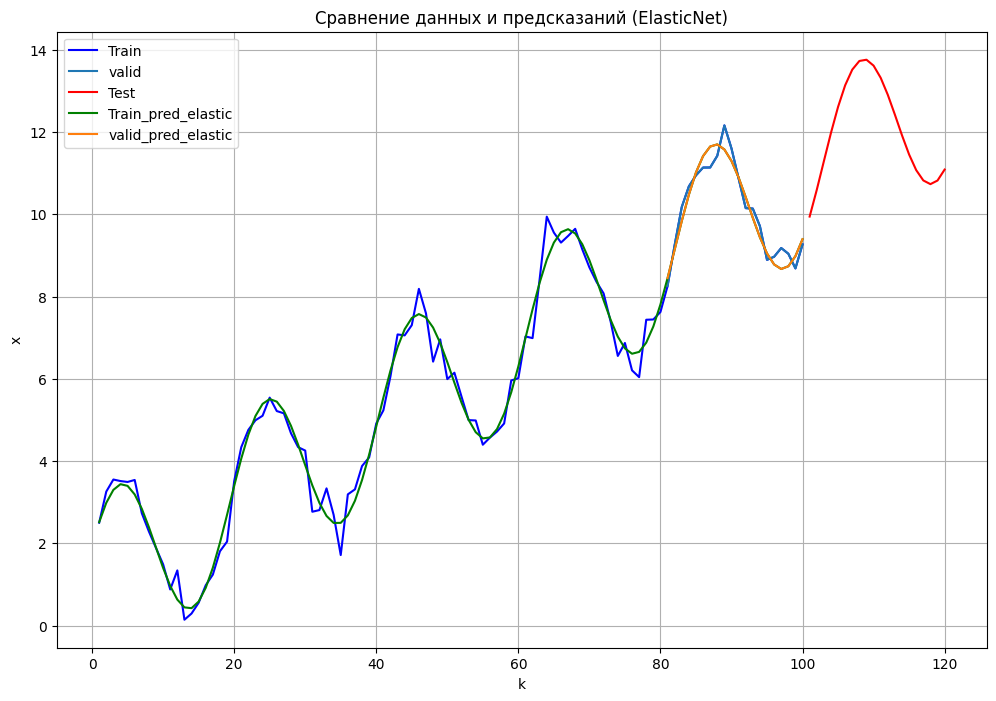

In [ ]:
# Визуализация
plt.figure(figsize = (12, 8))
plt.plot(train_data['k'], train_data['x'], label = 'Train', color = 'blue')
plt.plot(valid_data['k'], valid_data['x'], label = 'valid')
plt.plot(test_data['k'], test_data['x'], label='Test', color = 'red')
plt.plot(train_data['k'], train_data['pred_elastic_optim'], label = 'Train_pred_elastic', color = 'green')
plt.plot(valid_data['k'], valid_data['pred_elastic_optim'], label = 'valid_pred_elastic')
plt.xlabel('k')
plt.ylabel('x')
plt.title('Сравнение данных и предсказаний (ElasticNet)')
plt.legend()
plt.grid()
plt.show()